# Research question: 
## How do different areas of the US compare in regards to Twitter Sentiment? Are there particular areas in the US with remarkably high sentiment?

*Due to constraints mentioned in the READ_ME, I was only able to work with a subset of the data. The following statistics are based on a sample with 44,964 observations (tweets).*

Methodology: We partition the US into rectangles of the same dimension. We aim to find the average sentiment for each of these areas and compare. Each rectangle is denoted as a two-tuple (a,b). 

## Non-MRJob Implementation and analysis

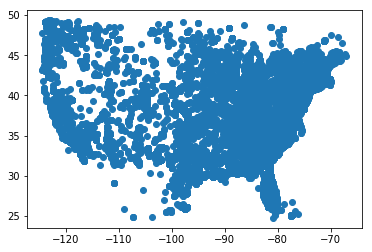

In [222]:
import json
data = []
with open("sentiment_and_ids.json") as f:
    for line in f:
        data.append(json.loads(line))
locations = [i["coordinates"]["coordinates"] for i in data]
loc_x = [i[0] for i in locations]
loc_y = [i[1] for i in locations]
sentiments = [i["sentiment"] for i in data]
import matplotlib.pyplot as plt
plt.scatter(loc_x, loc_y)

We observe that the data mostly covers the continental US. It appears that the density of tweets in the sample is greatest along areas near the east coast and is lowest in the midwest. 

In [239]:
import numpy as np
n = 360 #number of partitions
dy = (-65 - (-125)) / n
dx = (50 - 24) / n 
rectangles = {(i,j) : [-125 + dx * i, -125 + dx * (i+1), 24 + dy * j, 24 + dy * (j+1)] for i in range(n) for j in range(n)}
d = {}
for i,j,k in zip(loc_x, loc_y, sentiments):
    x_ind = int((i + 125) / dx)
    y_ind = int((j - 25) / dy)
    old_avg = (d.get((x_ind, y_ind), (0,0)))[0]
    old_freq = (d.get((x_ind, y_ind), (0,0)))[1]
    new_avg = (old_avg * old_freq + k)/(old_freq + 1)
    d[(x_ind, y_ind)] = (new_avg, old_freq + 1)

https://docs.scipy.org/doc/numpy/reference/generated/numpy.histogram2d.html

In [240]:
import pandas as pd
tweet_df = pd.DataFrame.from_dict(d, orient = "index", columns = ["Average Sentiment", "Number of Tweets"])
tweet_df.nlargest(5, "Number of Tweets")

,Average Sentiment,Number of Tweets
"(706, 94)",0.195755,2014
"(93, 54)",0.277538,704
"(517, 101)",0.235872,385
"(562, 52)",0.254299,370
"(664, 83)",0.209450,318


In [232]:
# The number of keys with observations
len(d.keys())

6635

In [217]:
# The number of keys with less than 5 observations. 
len(tweet_df[tweet_df["Number of Tweets"] < 5])

4794

We see that 72% of our clusters have less than 5 observations. Increasing the range of each rectangle would remedy this issue, but this incurs some loss of the ability to measure the effect of sentiment due to location. Weather may vary significantly if we make the rectangles larger, which would undermine our ability to measure the effect of sentiment and weather. 

Feel free to adjust the number of partitions (360) along each axis! 

## MRJob Implementation

In [167]:
import os
import tempfile

tmpdir = tempfile.mkdtemp()
file_one = os.path.join(tmpdir, 'module_one.py')


with open(file_one, 'w+') as fid:
    fid.write("""import module_4""")

In [168]:
%%file module_one.py

import module_4

Writing module_one.py


In [177]:
file_4 = os.path.join(tmpdir, 'module_4.py')
with open(file_4, 'w+') as fid:
    fid.write("""
    
from mrjob.job import MRJob
import json

n = 360 #number of partitions
dy = (-65 - (-125)) / n
dx = (50 - 24) / n 

class AvgSentiment(MRJob):

    def mapper(self, _, line):
        line = json.loads(line)
        sentiment = line["sentiment"]
        [loc_x, loc_y] = line["coordinates"]["coordinates"]
    
        x_ind = int((loc_x + 125) / dx)
        y_ind = int((loc_y - 25) / dy)
        
        yield (x_ind, y_ind), (sentiment, 1)
        
    def _reducer_combiner(self, square, senti_count):
        avg, count = 0, 0
        for sentiment, _ in senti_count:
            avg = (avg * count + sentiment) / (count + 1)
            count += 1
        return square, (avg, count)

    def combiner(self, square, senti_count):
        yield self._reducer_combiner(square, senti_count)

    def reducer(self, square, senti_count):
        square, (avg, count) = self._reducer_combiner(square, senti_count)
        yield square, (avg, count)

if __name__ == '__main__':
    AvgSentiment.run()

""")

In [178]:
%run $file_4 sentiment_and_ids.json

No configs found; falling back on auto-configuration
No configs found; falling back on auto-configuration
No configs found; falling back on auto-configuration
No configs found; falling back on auto-configuration
No configs found; falling back on auto-configuration
No configs found; falling back on auto-configuration
No configs found; falling back on auto-configuration
No configs found; falling back on auto-configuration
No configs found; falling back on auto-configuration
No configs found; falling back on auto-configuration
No configs found; falling back on auto-configuration
No configs specified for inline runner
No configs specified for inline runner
No configs specified for inline runner
No configs specified for inline runner
No configs specified for inline runner
No configs specified for inline runner
No configs specified for inline runner
No configs specified for inline runner
No configs specified for inline runner
No configs specified for inline runner
No configs specified for in

[10,110]	[0.0772,1]
[100,139]	[0.0,1]
[100,50]	[0.0,2]
[100,51]	[0.4457931818,11]
[100,52]	[0.2032666667,3]
[100,53]	[0.0,3]
[100,54]	[0.370675,12]
[100,55]	[0.0258,1]
[101,135]	[-0.23835,2]
[101,145]	[0.8225,1]
[101,50]	[0.37905,4]
[101,51]	[0.1151365385,13]
[101,52]	[0.0,1]
[101,53]	[0.6705,1]
[101,54]	[0.4024136364,11]
[101,56]	[0.0,1]
[101,63]	[-0.2545333333,3]
[102,134]	[0.1941,3]
[102,135]	[0.0772,1]
[102,50]	[-0.1039,2]
[102,51]	[0.4256666667,3]
[102,53]	[0.2513928571,7]
[102,54]	[0.2600694444,9]
[102,56]	[0.7863,1]
[103,135]	[0.1027,1]
[103,137]	[0.0,1]
[103,52]	[0.5423,1]
[103,53]	[0.37258125,8]
[103,54]	[0.499875,4]
[103,66]	[0.0,1]
[103,98]	[0.1461333333,3]
[104,135]	[0.3342475,16]
[104,136]	[0.177225,4]
[104,137]	[0.3612,1]
[104,49]	[0.5267,1]
[104,52]	[0.0,1]
[104,53]	[0.2083,3]
[104,54]	[0.15658,10]
[104,57]	[0.0,1]
[105,131]	[0.0,1]
[105,135]	[0.1300333333,3]
[105,136]	[0.0386,5]
[105,48]	[0.3827516667,9]
[105,49]	[0.3663127778,15]
[105,50]	[0.32655,1]
[105,52]	[0.2202,2

[507,108]	[0.0,1]
[507,109]	[0.0,1]
[507,112]	[0.49905,2]
[507,113]	[0.743,1]
[507,115]	[0.345275,4]
[507,46]	[0.1346,3]
[507,50]	[0.7964,1]
[507,69]	[0.07655,1]
[507,72]	[0.0,1]
[507,80]	[0.0772,1]
[507,86]	[0.0,2]
[507,87]	[0.6597,1]
[507,90]	[0.0258,1]
[508,100]	[0.7603,1]
[508,101]	[0.0105333333,6]
[508,102]	[0.22969,5]
[508,105]	[0.0382,1]
[508,108]	[0.028475,2]
[508,109]	[0.0772,1]
[508,115]	[0.5859,1]
[508,125]	[0.0,1]
[508,67]	[0.8519,1]
[508,89]	[0.0,1]
[508,90]	[0.1736516667,10]
[508,97]	[0.743,1]
[508,99]	[0.0,1]
[509,100]	[0.1521083333,4]
[509,101]	[0.3383333333,3]
[509,102]	[0.0,1]
[509,104]	[0.1275,3]
[509,108]	[0.25087,10]
[509,110]	[0.0,1]
[509,33]	[0.0386,2]
[509,34]	[0.4812433333,5]
[509,45]	[0.4189,2]
[509,86]	[-0.3818,1]
[509,87]	[0.4588,1]
[509,90]	[0.2770714286,7]
[509,97]	[0.0772,1]
[509,99]	[0.2071333333,3]
[51,112]	[0.5994,1]
[51,114]	[0.2215518519,9]
[51,124]	[0.0,1]
[51,133]	[0.0,1]
[51,65]	[-0.5984,1]
[51,75]	[-0.6369,1]
[51,76]	[0.6361,2]
[51,77]	[0.0348644

[622,46]	[0.47289,5]
[622,47]	[0.057975,7]
[622,49]	[0.0772,1]
[622,65]	[0.3040166667,6]
[622,73]	[0.1199833333,6]
[622,74]	[0.0,1]
[622,7]	[0.4215,1]
[622,84]	[0.4043666667,3]
[622,86]	[0.296,1]
[622,8]	[0.4213214286,7]
[622,91]	[0.0,1]
[622,92]	[0.1298510243,16]
[622,93]	[0.08808,5]
[622,94]	[-0.0386,2]
[622,9]	[0.3411666667,9]
[623,101]	[-0.8402,1]
[623,109]	[0.0,3]
[623,110]	[0.0,1]
[623,45]	[0.275025,2]
[623,46]	[0.1894583333,12]
[623,47]	[0.3008512821,13]
[623,49]	[0.0,1]
[623,54]	[0.0,1]
[623,63]	[0.38205,11]
[623,65]	[0.1947333333,10]
[623,66]	[0.0,2]
[623,67]	[0.0,1]
[623,70]	[0.296,1]
[623,73]	[0.4140037778,15]
[623,74]	[0.35298,5]
[623,76]	[0.5267,1]
[623,83]	[0.0,1]
[623,87]	[0.3262969697,11]
[623,92]	[0.2630561905,16]
[623,93]	[0.1297,2]
[623,94]	[0.59225,2]
[623,95]	[0.8519,1]
[624,109]	[0.2709083333,11]
[624,110]	[0.0,1]
[624,111]	[0.3723,5]
[624,115]	[0.4588,1]
[624,137]	[0.5106,1]
[624,46]	[0.3741800397,12]
[624,47]	[0.7824,1]
[624,55]	[0.8519,1]
[624,58]	[0.0,1]
[624,

[95,121]	[0.0,2]
[95,52]	[0.281245,15]
[95,53]	[0.3439897436,13]
[95,54]	[0.1441902778,12]
[95,55]	[0.5994,1]
[95,57]	[0.22475,4]
[95,58]	[0.0,1]
[96,51]	[0.24834375,12]
[96,52]	[0.279539697,11]
[96,53]	[0.1731910256,13]
[96,54]	[0.2743678571,14]
[96,55]	[0.4404,1]
[97,51]	[0.1945866667,5]
[97,52]	[0.3379314286,14]
[97,53]	[0.2784416667,10]
[97,54]	[0.4066666667,10]
[97,60]	[0.0,1]
[98,141]	[0.1481333333,3]
[98,51]	[0.2289525556,15]
[98,52]	[0.2537656473,16]
[98,53]	[0.135682568,14]
[98,54]	[0.1342989583,8]
[99,121]	[0.5859,1]
[99,144]	[0.0,1]
[99,51]	[0.2378190476,7]
[99,52]	[0.2860223809,14]
[99,53]	[0.29635625,8]
[99,54]	[0.2155833333,11]
[99,57]	[0.0,2]


Removing temp directory C:\Users\KHALIL~1\AppData\Local\Temp\module_4.Khalil.20190601.112358.087228...
Removing temp directory C:\Users\KHALIL~1\AppData\Local\Temp\module_4.Khalil.20190601.112358.087228...
Removing temp directory C:\Users\KHALIL~1\AppData\Local\Temp\module_4.Khalil.20190601.112358.087228...
Removing temp directory C:\Users\KHALIL~1\AppData\Local\Temp\module_4.Khalil.20190601.112358.087228...
Removing temp directory C:\Users\KHALIL~1\AppData\Local\Temp\module_4.Khalil.20190601.112358.087228...
Removing temp directory C:\Users\KHALIL~1\AppData\Local\Temp\module_4.Khalil.20190601.112358.087228...
Removing temp directory C:\Users\KHALIL~1\AppData\Local\Temp\module_4.Khalil.20190601.112358.087228...
Removing temp directory C:\Users\KHALIL~1\AppData\Local\Temp\module_4.Khalil.20190601.112358.087228...
Removing temp directory C:\Users\KHALIL~1\AppData\Local\Temp\module_4.Khalil.20190601.112358.087228...
Removing temp directory C:\Users\KHALIL~1\AppData\Local\Temp\module_4.Kha